In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/project733/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/project733


In [2]:
import pandas as pd
# data processing import 
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# data vectorization import
import torch 
import sklearn
from torchtext.vocab import GloVe
import numpy as np

#training on k-means clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [4]:
data = pd.read_csv('Electronics.gz', nrows=1500000, compression='gzip',sep='\t',on_bad_lines='skip')

data = data.dropna()

data.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [5]:
cols_remain = ['product_id', 'product_parent', 'product_title']


data_sample = data[cols_remain]
data_sample.drop_duplicates(subset=['product_id','product_title'])


display(data_sample)

,product_id,product_parent,product_title
0,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...
1,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor"
2,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier
3,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...
4,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker
...,...,...,...
1499995,B00FZ41S84,881423525,6 inch 40-Pin IDE Male to Female Extension Cab...
1499996,B00264GYMG,892243207,Klipsch Image S4i Premium Noise-Isolating Head...
1499997,B008LCYIH0,767044853,Military Grade Drop Protection
1499998,B00ADCVG0S,440422084,Sony ICF-M260 AM/FM PLL Synthesized Clock Radi...


##Preprocess Text

in order to make text lower case and remove stop_words

In [6]:

def preprocess_text(text, stop_words):
    # Convert text to lowercase
    if text.isdigit():
      return None
    else:
      text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Tokenize text into words
    words = word_tokenize(text)
   
    # Remove stop words
    filtered_words = [word for word in words if word not in stop_words]
  
    return filtered_words

stop_words = set(stopwords.words("english"))
data_sample['processed_words_list']= data_sample['product_title'].apply(lambda x: preprocess_text(str(x), stop_words))


display(data_sample)
# processed_text = preprocess_text(text,stop_words)

<ipython-input-6-611ea35193b1>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sample['processed_words_list']= data_sample['product_title'].apply(lambda x: preprocess_text(str(x), stop_words))


,product_id,product_parent,product_title,processed_words_list
0,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,"[yoomall, 5m, antenna, wifi, rpsma, female, ma..."
1,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor","[hosa, gpm103, 35mm, trs, 14, trs, adaptor]"
2,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,"[channel, master, titan, 2, antenna, preamplif..."
3,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,"[limtech, wall, charger, usb, hotsync, chargin..."
4,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,"[skullcandy, air, raid, portable, bluetooth, s..."
...,...,...,...,...
1499995,B00FZ41S84,881423525,6 inch 40-Pin IDE Male to Female Extension Cab...,"[6, inch, 40pin, ide, male, female, extension,..."
1499996,B00264GYMG,892243207,Klipsch Image S4i Premium Noise-Isolating Head...,"[klipsch, image, s4i, premium, noiseisolating,..."
1499997,B008LCYIH0,767044853,Military Grade Drop Protection,"[military, grade, drop, protection]"
1499998,B00ADCVG0S,440422084,Sony ICF-M260 AM/FM PLL Synthesized Clock Radi...,"[sony, icfm260, amfm, pll, synthesized, clock,..."


##Vectorization

In order to change the word vector into the shape shape, torch mean is used to get the mean of all the word vectors to maintain the shape of the product of [300,]

In [7]:
def vectorization(glove_vectors,w_list):
  if len(w_list) == 0:
    return None
  embedding = glove_vectors.get_vecs_by_tokens(w_list)
  final_vector = torch.mean(embedding, dim=0)
  final_vector = final_vector.tolist()
  final_vector = np.array(final_vector)
  return final_vector

data_sample = data_sample.dropna()
glove_vectors = GloVe(name="6B")
EMBEDDING_DIM = glove_vectors.vectors.shape[1]
# vec = vectorization(glove_vectors,w_list)

data_sample['processed_words_vec']= data_sample['processed_words_list'].apply(lambda x: vectorization(glove_vectors,x))

display(data_sample)

,product_id,product_parent,product_title,processed_words_list,processed_words_vec
0,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,"[yoomall, 5m, antenna, wifi, rpsma, female, ma...","[-0.12775488197803497, 0.04657214134931564, -0..."
1,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor","[hosa, gpm103, 35mm, trs, 14, trs, adaptor]","[-0.2895675599575043, -0.25948256254196167, -0..."
2,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,"[channel, master, titan, 2, antenna, preamplif...","[-0.1297074556350708, 0.024153338745236397, 0...."
3,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,"[limtech, wall, charger, usb, hotsync, chargin...","[-0.1278451681137085, 0.029575470834970474, -0..."
4,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,"[skullcandy, air, raid, portable, bluetooth, s...","[-0.20284150540828705, 0.04889601469039917, 0...."
...,...,...,...,...,...
1499995,B00FZ41S84,881423525,6 inch 40-Pin IDE Male to Female Extension Cab...,"[6, inch, 40pin, ide, male, female, extension,...","[-0.19342711567878723, 0.012970004230737686, -..."
1499996,B00264GYMG,892243207,Klipsch Image S4i Premium Noise-Isolating Head...,"[klipsch, image, s4i, premium, noiseisolating,...","[-0.06095225363969803, 0.02174299955368042, 0...."
1499997,B008LCYIH0,767044853,Military Grade Drop Protection,"[military, grade, drop, protection]","[-0.07589750736951828, 0.1909475028514862, -0...."
1499998,B00ADCVG0S,440422084,Sony ICF-M260 AM/FM PLL Synthesized Clock Radi...,"[sony, icfm260, amfm, pll, synthesized, clock,...","[-0.09897659718990326, 0.007101596798747778, 0..."


## Training and Ploting
Due to the meaning of product parent, I add it to the features for categorization

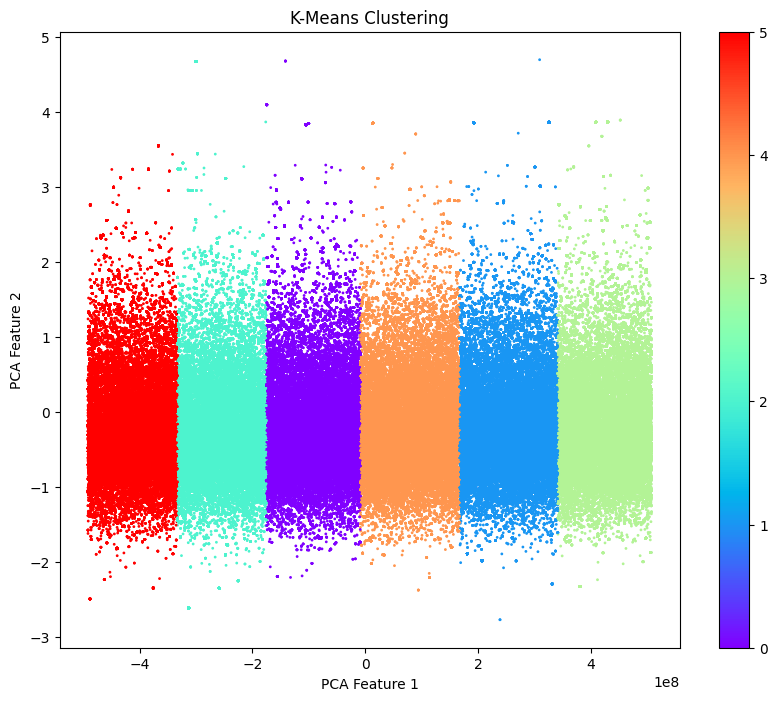

In [8]:
data_sample = data_sample.dropna()
df_processed_words_vec = data_sample['processed_words_vec'].apply(pd.Series)
df_product_parent = data_sample[['product_parent']]
df_product_parent = df_product_parent.rename(columns={"product_parent": 300})
X = df_product_parent.merge(df_processed_words_vec,left_index=True, right_index=True)

kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto")
y_predict= kmeans.fit_predict(X)


# Apply PCA to reduce the dimensionality of the data to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualize the clusters
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data points colored by cluster
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_predict, cmap='rainbow',s=1)

# Add axis labels and a title
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_title('K-Means Clustering')

# Add a colorbar legend
plt.colorbar(scatter)